In [22]:
import ghost
import pandas as pd
import os
import bids
import ants
from ghost.bids import unity_qa_process_subject
import seaborn as sns
import matplotlib.pyplot as plt
from ghost.phantom import Caliber137
from nilearn import plotting
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway


In [2]:
projdir = '/home/em2876lj/Projects/QA/QA_paper/project'
subses = pd.read_csv(os.path.join(projdir, 'code', 'slurm', 'all_sessions.txt'), delimiter=' ', names=['Subject', 'Session'])
layout = bids.BIDSLayout(root=projdir+'/rawdata', derivatives=projdir+'/derivatives')

In [3]:
all_rows = []
for i,row in subses.iterrows():
    
    d = {'Subject':row.Subject, 'Session':row.Session, 'PSNR':None}
    
    try:
        psnr_f = layout.get(scope='derivatives', subject=row.Subject, session=row.Session, extension='.txt', desc='PSNR')[0]
    except:
        print(f'No PSNR for {row.Subject} {row.Session}')

    with open(psnr_f, 'r') as f:
        d['PSNR'] = float(f.readline())

    all_rows.append(d)

No PSNR for P0020 20240322121526
No PSNR for P0029 20240301115421
No PSNR for P0029 20240319111148


In [4]:
df = pd.DataFrame(all_rows)
df = df.drop(df[df['PSNR'] == np.inf].index).reset_index()

In [5]:
# Summary of PSNR
print(df['PSNR'].min())
print(df['PSNR'].max())
print(df['PSNR'].mean())

28.07539
35.75752
33.16909926859504


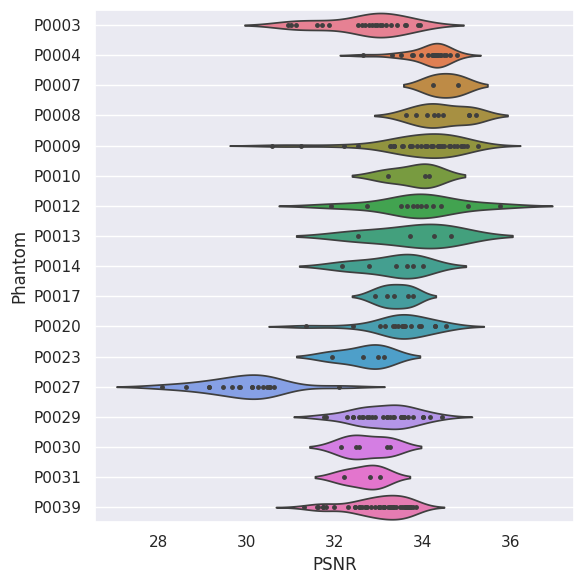

In [6]:
sns.set_theme()
plt.figure(figsize=(6,6))
sns.violinplot(data=df, y='Subject', x='PSNR', hue='Subject', inner='point', alpha=1, orient='h')
# sns.stripplot(data=df, y='Subject', x='PSNR', s=10, hue='Subject', alpha=0.3, orient='h')
# sns.pointplot(data=df, y='Subject', x='PSNR', hue='Subject', markersize=10, markers='d', errorbar=None, orient='h')
plt.ylabel('Phantom')
plt.xlabel('PSNR')
plt.grid()
plt.tight_layout()
plt.show()

In [29]:
# One-way anova between sites
psnr_data = df['PSNR']
groups = df['Subject']
res = anova_oneway(psnr_data, groups)
print(res)

statistic = 18.770013195540088
pvalue = 1.8550244325104862e-10
df = (16.0, np.float64(26.39284372069861))
df_num = 16.0
df_denom = 26.39284372069861
nobs_t = 242.0
n_groups = 17
means = [32.67107309 34.12754657 34.5229665  34.44482011 33.90853749 33.80473467
     33.91558167 33.789901   33.3003595  33.386538   33.47702153 32.67839775
     29.93616418 33.14094238 32.7293968  32.69034567 32.95600007]
nobs = [22. 21.  2.  9. 37.  3. 12.  4.  6.  5. 17.  4. 17. 29.  5.  3. 46.]
vars_ = [0.8311323  0.24401143 0.15241438 0.31563761 0.99183828 0.26094073
     0.96496939 0.85289394 0.48474724 0.12666866 0.56265506 0.28467854
     0.82988219 0.45037121 0.23765842 0.17537909 0.45822324]
use_var = unequal
welch_correction = True
tuple = (np.float64(18.770013195540088), np.float64(1.8550244325104862e-10))


In [7]:
# Example images with different PSNR
my_psnr = [28,30,31,33,34,35]
id_psnr = []
for psnr in my_psnr:
    id_psnr.append((df['PSNR']-psnr).abs().idxmin())

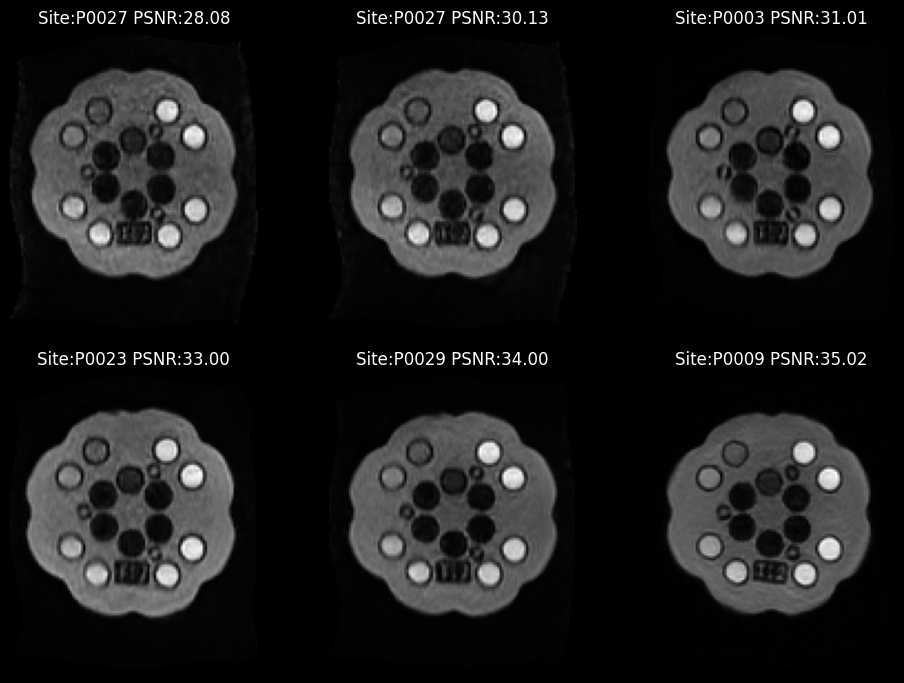

In [8]:
plt.style.use('dark_background')
fig, axes = plt.subplots(2,3,figsize=(10,7))
for i in range(6):
    ax = axes[np.unravel_index(i,(2,3))]
    row = df.loc[id_psnr[i]]
    img = layout.get(scope='raw', extension='.nii.gz', subject=row.Subject, reconstruction='axi', session=row.Session, run=1)[0].get_image().get_fdata()
    ax.imshow(np.rot90(img[:,:,14]), cmap='gray')
    ax.set_title(f'Site:{row.Subject} PSNR:{row.PSNR:.2f}')
    ax.axis('off')

plt.tight_layout()


In [9]:
# Read in temperature
df_temp = pd.read_csv('/home/em2876lj/Projects/QA/QA_paper/project/derivatives/fisp_temperature_w0.csv')

In [10]:
df_temp['Temperature'] = 24-df_temp['n_black']
df_temp['Larmour'] = df_temp['w0']*1E6

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Larmour     
No. Observations:      244          Method:                  REML        
No. Groups:            17           Scale:                   4018387.5882
Min. group size:       2            Log-Likelihood:          -2238.2124  
Max. group size:       47           Converged:               Yes         
Mean group size:       14.4                                              
-------------------------------------------------------------------------
                Coef.      Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------
Intercept     2753807.840  4633.208 594.363 0.000 2744726.919 2762888.761
Temperature     -1974.062   135.822 -14.534 0.000   -2240.269   -1707.856
Group Var   211062583.051 38639.319                                      



In [12]:
# Ordinary least squares
y = df_temp.Larmour
X = sm.add_constant(df_temp.Temperature)
mod = sm.OLS(y,X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Larmour   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.988
Date:                Thu, 04 Jul 2024   Prob (F-statistic):             0.0151
Time:                        14:02:59   Log-Likelihood:                -2650.0
No. Observations:                 244   AIC:                             5304.
Df Residuals:                     242   BIC:                             5311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        2.735e+06   9729.952    281.047      

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      Larmour     
No. Observations:      244          Method:                  REML        
No. Groups:            17           Scale:                   4018387.5882
Min. group size:       2            Log-Likelihood:          -2238.2124  
Max. group size:       47           Converged:               Yes         
Mean group size:       14.4                                              
-------------------------------------------------------------------------
                Coef.      Std.Err.    z    P>|z|    [0.025      0.975]  
-------------------------------------------------------------------------
Intercept     2753807.840  4633.208 594.363 0.000 2744726.919 2762888.761
Temperature     -1974.062   135.822 -14.534 0.000   -2240.269   -1707.856
Group Var   211062583.051 38639.319                                      



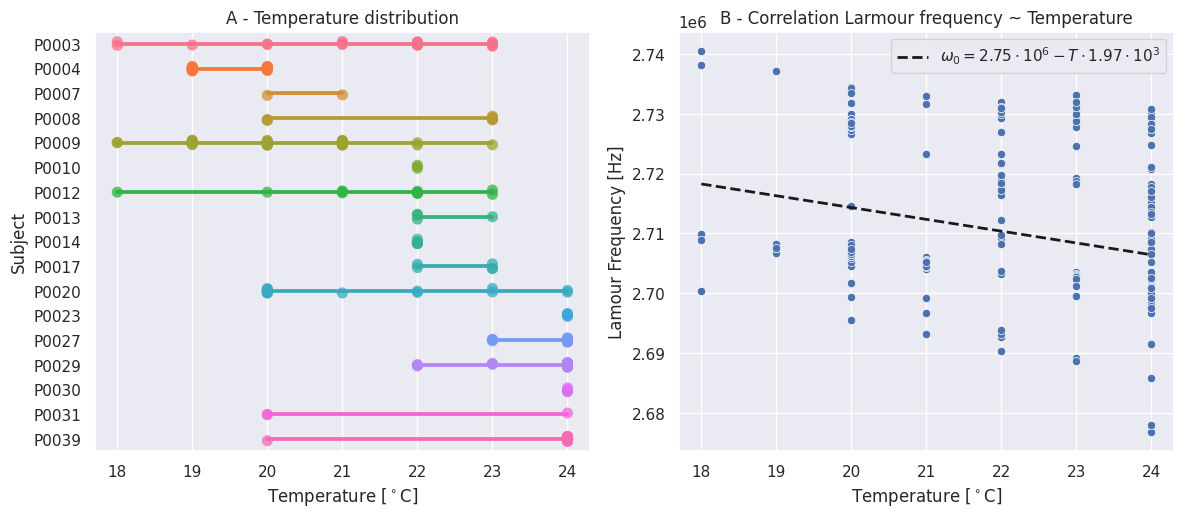

--- mixedLM p-values ---
Intercept      0.000000e+00
Temperature    7.361880e-48
Group Var      6.431449e-03
dtype: float64


In [20]:
# Linear mixed effects model 
md = smf.mixedlm("Larmour ~ Temperature", df_temp, groups=df_temp['Subject'])
mdf = md.fit(method=['lbfgs'])
print(mdf.summary())

sns.set_theme()
fig, axes = plt.subplots(1,2,figsize=(12,5.5))

ax = axes[0]
sns.stripplot(data=df_temp, y='Subject', x='Temperature', s=8, hue='Subject', alpha=0.75, orient='h', dodge=False, ax=ax)
sns.pointplot(data=df_temp, y='Subject', x='Temperature', hue='Subject', markersize=0, 
                markers='d', errorbar=lambda x: (x.min(), x.max()),  orient='h', ax=ax)
# sns.histplot(df_temp, x='Temperature', hue='Subject', bins=np.arange(14,25), ax=ax, palette='dark')

# ax.set_ylabel('Phantom')
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.set_title('A - Temperature distribution')
# ax.grid()

ax = axes[1]
sns.scatterplot(data=df_temp, x='Temperature', y='Larmour',ax=ax)
x = np.arange(18,25)

m_base, m_exp = f"{mdf.params.Intercept:.2e}".split('e')
k_base, k_exp = f"{abs(mdf.params.Temperature):.2e}".split('e')

if mdf.params.Temperature < 0:
        sign = '-'
else:
        sign = '+'

plt.plot(x, mdf.params.Intercept + mdf.params.Temperature*x, '--k', 
        linewidth=2, label=rf'$\omega_0 = {m_base}\cdot 10^{int(m_exp)} {sign} T \cdot {k_base} \cdot 10^{int(k_exp)} $')
ax.legend()
ax.set_xlabel(r'Temperature [$^\circ$C]')
ax.set_ylabel('Lamour Frequency [Hz]')
ax.set_title('B - Correlation Larmour frequency ~ Temperature')

plt.tight_layout()
plt.show()

print("--- mixedLM p-values ---")
print(mdf.pvalues)

In [14]:
# Now correlation between temperature and SNR
# Match the two dataframes
df_comb = df_temp.copy()
df_comb['PSNR'] = None

for i,row in df_comb.iterrows():
    PSNR = df[(df['Subject']==row.Subject) & (df['Session']==row.Session)]['PSNR']
    try:
        df_comb.at[i,'PSNR'] = float(PSNR.values[0])
    except:
        print(PSNR)

df_comb = df_comb[~df_comb['PSNR'].isna()]
df_comb['PSNR'] = df_comb['PSNR'].astype('float64')

Series([], Name: PSNR, dtype: float64)
Series([], Name: PSNR, dtype: float64)


                            OLS Regression Results                            
Dep. Variable:                   PSNR   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     31.66
Date:                Thu, 04 Jul 2024   Prob (F-statistic):           5.09e-08
Time:                        14:03:00   Log-Likelihood:                -386.78
No. Observations:                 242   AIC:                             777.6
Df Residuals:                     240   BIC:                             784.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.2552     16.365      7.654      0.0

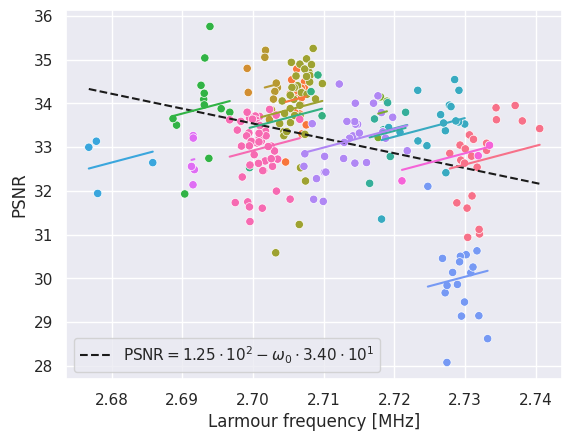

In [15]:
# Ordinary least squares
y = df_comb.PSNR
X = sm.add_constant(df_comb.w0)
mod = sm.OLS(y,X)
res = mod.fit()
slope = res.params.w0
intercept = res.params.const
print(res.summary())

# mixedLM doesn't work here since the data is grouped a lot and doesn't make sense to look at individual groups then.
# md = smf.mixedlm("PSNR ~ w0", df_comb, groups=df_comb['Subject'])
# res = md.fit(method=['lbfgs'])
# slope = res.params.w0
# intercept = res.params.Intercept

# print(res.summary())

fig, ax = plt.subplots(1,1)
sns.scatterplot(data=df_comb, x='w0', y='PSNR', hue='Subject', ax=ax)
x = np.linspace(df_comb['w0'].min(),df_comb['w0'].max())

m_base, m_exp = f"{intercept:.2e}".split('e')
k_base, k_exp = f"{abs(slope):.2e}".split('e')

if slope < 0:
    sign = '-'
else:
    sign = '+'

ax.plot(x, intercept + x*slope, '--k', label=rf'PSNR$ = {m_base}\cdot 10^{int(m_exp)} {sign} \omega_0 \cdot {k_base} \cdot 10^{int(k_exp)} $')

# Remove seaborn legend entries
handles, labels = ax.get_legend_handles_labels()
handles = [handle for handle, label in zip(handles, labels) if 'P0' not in label]
labels = [label for label in labels if 'P0' not in label]
ax.legend(handles=handles, labels=labels)


# mixedLM doesn't work here since the data is grouped a lot and doesn't make sense to look at individual groups then.
md = smf.mixedlm("PSNR ~ w0", df_comb, groups=df_comb['Subject'])
res = md.fit(method=['lbfgs'])
slope = res.params.w0
intercept = res.params.Intercept
print(res.summary())

for l in ax.get_lines():
    ll = l.get_label()
    if 'P0' in ll:
        c = l.get_color()
        xmin = df_comb[df_comb['Subject']==ll]['w0'].min()
        xmax = df_comb[df_comb['Subject']==ll]['w0'].max()
        x = np.linspace(xmin, xmax)
        inter = res.random_effects[ll].Group
        plt.plot(x, x*slope + inter + intercept, color=c)

ax.set_xlabel('Larmour frequency [MHz]')
plt.show()